#                                        Expedia Project

In [1]:
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import datetime


# Phase 1  - Data Pre Processing

In [2]:
df = pd.read_csv('Expedia.csv', index_col=False)
df

,Name,DateOfSearch,Checkin,Checkout,NumOfWeekendDays,Nights,District,Score,Rating,Review,Includes,Refundable,Price,TTT
0,The Hoxton Williamsburg,2023/3/1,2023/3/2,2023/3/3,0,1,Williamsburg,9.0,Wonderful,"(1,000 reviews)",NaN,Fully refundable,$347 total,1
1,Hampton Inn Manhattan/Times Square Central,2023/3/1,2023/3/2,2023/3/3,0,1,Theater District,8.6,Excellent,"(1,338 reviews)",Breakfast included,Fully refundable,$381 total,1
2,Cachet Boutique New York,2023/3/1,2023/3/2,2023/3/3,0,1,New York,7.6,Good,"(1,002 reviews)",NaN,0,$287 total,1
3,"PUBLIC, an Ian Schrager hotel",2023/3/1,2023/3/2,2023/3/3,0,1,New York,8.0,Very Good,"(1,447 reviews)",NaN,0,$446 total,1
4,Hampton Inn NY-JFK,2023/3/1,2023/3/2,2023/3/3,0,1,Queens,7.6,Good,"(1,216 reviews)",Breakfast included,0,$181 total,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40492,Fitzpatrick Manhattan Hotel,2023/3/3,2023/4/1,2023/4/6,2,5,New York,8.8,Excellent,"(1,001 reviews)",NaN,Fully refundable,$380 total,3
40493,Hilton Club West 57th Street New York,2023/3/3,2023/4/1,2023/4/6,2,5,New York,9.2,Wonderful,(223 reviews),NaN,0,$395 total,3
40494,Roxy Hotel New York,2023/3/3,2023/4/1,2023/4/6,2,5,New York,9.0,Wonderful,"(1,000 reviews)",NaN,Fully refundable,$512 total,3
40495,Equinox Hotel New York,2023/3/3,2023/4/1,2023/4/6,2,5,New York,9.0,Wonderful,(304 reviews),Pool,0,$908 total,3


In [3]:
df.isna().sum()

Name                    0
DateOfSearch            0
Checkin                 0
Checkout                0
NumOfWeekendDays        0
Nights                  0
District                0
Score                 850
Rating                850
Review               2316
Includes            32851
Refundable              0
Price                   0
TTT                     0
dtype: int64

In [4]:
df = df[df['Score'].notna() & df['Rating'].notna()]

## Data Transforamtion

In [5]:
def review_cleaning(df: pd.DataFrame):
    df['Review'] = df['Review'].str.replace('(','').str.replace(')','').str.replace(',','').str.replace(' reviews', '').str.strip()
    df.Review = pd.to_numeric(df.Review, errors='coerce')
    df.Review = df.Review.fillna(df.Review.mean())


def price_cleaning(df: pd.DataFrame):
    df.Price = df.Price.str.replace("$",'', regex=True).str.replace(" total",'').str.replace(',','').str.strip().fillna(0)
    df.Price = pd.to_numeric(df.Price, errors='coerce')
    df.Price = df.Price * df.Nights

def rating_cleaning(df: pd.DataFrame):
    ratings = {'Good', 'Very Good', 'Excellent', 'Wonderful', 'Exceptional'}
    df['Rating'] = df['Rating'].astype(str)
    df['Rating'] = df['Rating'].str.replace('(','').str.replace(')','').str.replace(',','').str.replace(' reviews', '')
    df['Rating'].fillna('Very Good', inplace=True)
    for index, row in df.iterrows():
        if row.Rating not in ratings:
            df.at[index, 'Rating'] = 'Very Good'

def get_day_of_week(date_obj):
    date_obj = datetime.datetime.strptime(date_obj, '%Y/%m/%d')
    day_of_week = date_obj.strftime('%A')
    return day_of_week

def encode_ratings(df: pd.DataFrame):
    categories = [['Good', 'Very Good', 'Excellent','Wonderful', 'Exceptional']]
    encoder = OrdinalEncoder(categories=categories)
    rating_encoded = encoder.fit_transform(df[['Rating']])
    df['Rating'] = rating_encoded

def incode_names(df: pd.DataFrame):
    df.columns = df.columns.str.strip()
    one_hot_encoded = pd.get_dummies(df, columns=['Includes', 'District', 'Checkin', 'Checkout'])
    df_encoded = pd.concat([df, one_hot_encoded], axis=1)
    df_encoded = df_encoded.drop(columns=['Includes','District', 'Checkin', 'Checkout'], axis=1)
    return df_encoded

def encode_refundable(df: pd.DataFrame):
    df['Refundable'] = df['Refundable'].apply(lambda x: 1 if x == 'Fully refundable' else 0)

def encode_columns(df: pd.DataFrame):
    df['NumOfWeekendDays'] = df['NumOfWeekendDays'].astype(float)
    df['Nights'] = df['Nights'].astype(float)
    df['Score'] = pd.to_numeric(df['Score'])
    df['Rating'] = df['Rating'].astype(float)
    df['Includes'].fillna('other', inplace=True)
    df['Score'] = df['Score'].fillna(df.Score.mean())


In [6]:
df_cleaned = df.copy()

In [7]:
df_cleaned.Checkin = df_cleaned.Checkin.apply(lambda x: get_day_of_week(x))
df_cleaned.Checkout = df_cleaned.Checkout.apply(lambda x: get_day_of_week(x))

In [8]:
df_cleaned.drop(columns=['DateOfSearch'], inplace=True)

In [9]:
review_cleaning(df_cleaned)
price_cleaning(df_cleaned)
rating_cleaning(df_cleaned)
encode_ratings(df_cleaned)
encode_refundable(df_cleaned)
encode_columns(df_cleaned)
df_cleaned = incode_names(df_cleaned)


In [10]:
df_cleaned = df_cleaned.loc[:, ~df_cleaned.columns.duplicated()]

In [11]:
df_cleaned[['Price', 'Score', 'Review', 'Rating','Nights']].describe().T

,count,mean,std,min,25%,50%,75%,max
Price,39647.0,1038.849699,706.956634,110.0,516.0,900.0,1392.0,6330.0
Score,39647.0,8.344445,0.703089,5.0,8.0,8.4,8.8,10.0
Review,39647.0,1135.020395,664.262290,8.0,1000.0,1003.0,1209.0,6339.0
Rating,39647.0,1.557747,1.101328,0.0,1.0,1.0,2.0,4.0
Nights,39647.0,2.978334,1.420517,1.0,2.0,3.0,4.0,5.0



## Outliers removal using Tuky method

In [12]:
Q1 = df_cleaned['Price'].quantile(0.25)
Q3 = df_cleaned['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

df_cleaned = df_cleaned[(df_cleaned['Price'] >= lower_bound) & (df_cleaned['Price'] <= upper_bound)]

# Distribution of Price, Reviews and Score

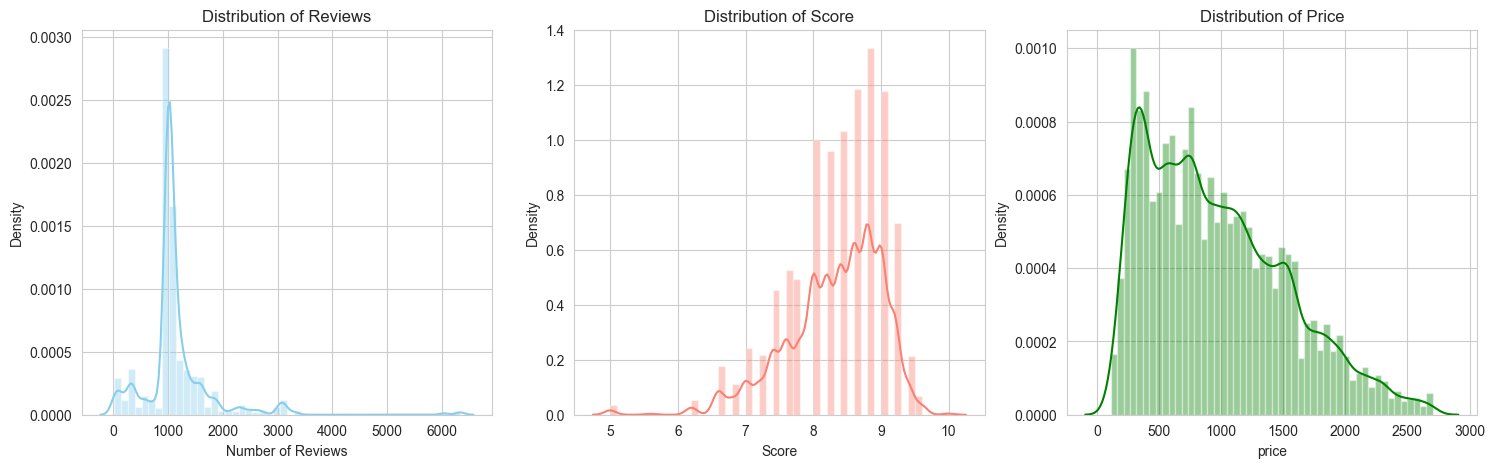

In [13]:
sns.set_style("whitegrid")
sns.set_palette("husl")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Distribution plot for num_of_reviews column
sns.distplot(df_cleaned['Review'], ax=ax1, color='skyblue')
ax1.set_title('Distribution of Reviews')
ax1.set_xlabel('Number of Reviews')
ax1.set_ylabel('Density')

# Distribution plot for score column
sns.distplot(df_cleaned['Score'], ax=ax2, color='salmon')
ax2.set_title('Distribution of Score')
ax2.set_xlabel('Score')
ax2.set_ylabel('Density')

sns.distplot(df_cleaned['Price'], ax=ax3, color='green')
ax3.set_title('Distribution of Price')
ax3.set_xlabel('price')
ax3.set_ylabel('Density')

# Display the plot
plt.show()

# Phase 2 -  Price Prediction

In [14]:
df_cleaned

,Name,NumOfWeekendDays,Nights,Score,Rating,Review,Refundable,Price,TTT,Includes_Airport shuttle included,...,Checkin_Thursday,Checkin_Tuesday,Checkin_Wednesday,Checkout_Friday,Checkout_Monday,Checkout_Saturday,Checkout_Sunday,Checkout_Thursday,Checkout_Tuesday,Checkout_Wednesday
0,The Hoxton Williamsburg,0.0,1.0,9.0,3.0,1000.000000,1,347,1,0,...,1,0,0,1,0,0,0,0,0,0
1,Hampton Inn Manhattan/Times Square Central,0.0,1.0,8.6,2.0,1338.000000,1,381,1,0,...,1,0,0,1,0,0,0,0,0,0
2,Cachet Boutique New York,0.0,1.0,7.6,0.0,1002.000000,0,287,1,0,...,1,0,0,1,0,0,0,0,0,0
3,"PUBLIC, an Ian Schrager hotel",0.0,1.0,8.0,1.0,1447.000000,0,446,1,0,...,1,0,0,1,0,0,0,0,0,0
4,Hampton Inn NY-JFK,0.0,1.0,7.6,0.0,1216.000000,0,181,1,0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40491,Fitzpatrick Grand Central,2.0,5.0,9.0,3.0,1000.000000,1,1840,3,0,...,0,0,0,0,0,0,0,1,0,0
40492,Fitzpatrick Manhattan Hotel,2.0,5.0,8.8,2.0,1001.000000,1,1900,3,0,...,0,0,0,0,0,0,0,1,0,0
40493,Hilton Club West 57th Street New York,2.0,5.0,9.2,3.0,223.000000,0,1975,3,0,...,0,0,0,0,0,0,0,1,0,0
40494,Roxy Hotel New York,2.0,5.0,9.0,3.0,1000.000000,1,2560,3,0,...,0,0,0,0,0,0,0,1,0,0


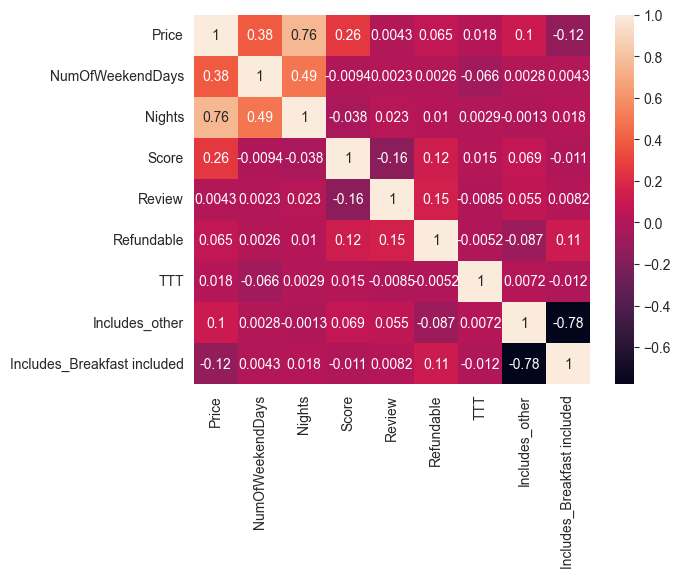

In [15]:
df_cor = df_cleaned[['Price', 'NumOfWeekendDays','Nights', 'Score','Review', 'Refundable','TTT', 'Includes_other','Includes_Breakfast included']]
sns.heatmap(df_cor.corr(), annot=True);

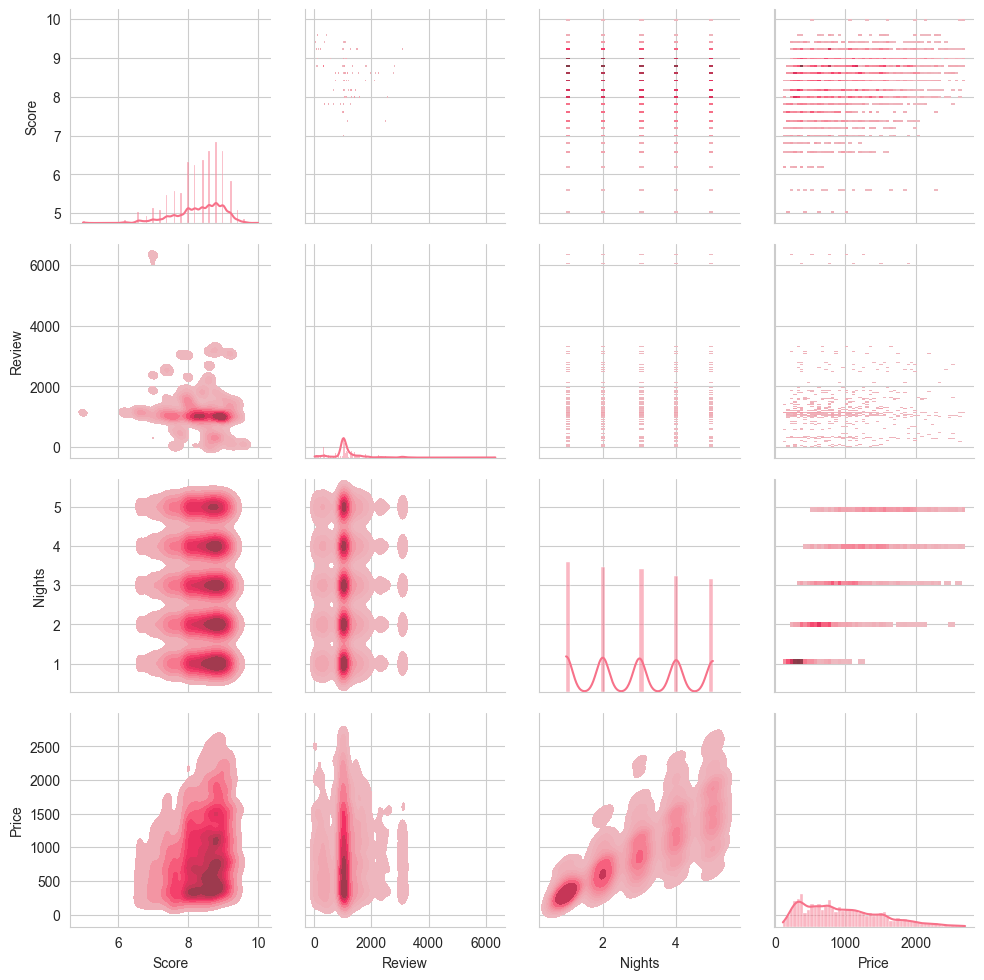

In [16]:
g = sns.PairGrid(df_cleaned, vars=["Score", "Review", "Nights", "Price"])
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True);

In [17]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, CompoundKernel
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import xgboost as xgb

# Linear Regression

r^2 is  0.7235655782358485
MSE Test  86578.42586607256
MSE Train  90819.2691781799


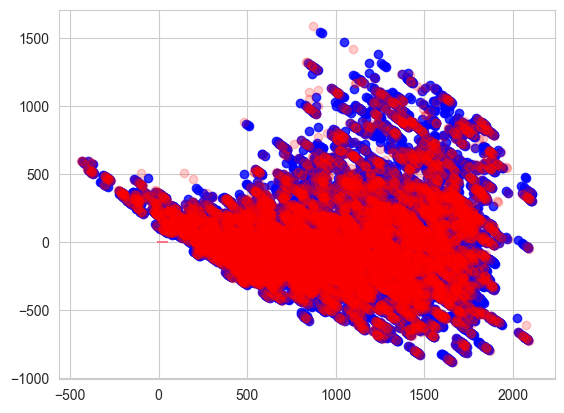

In [18]:
X = df_cleaned.drop(['Price','Name','Nights','Includes_Breakfast included'], axis=1)
y = df_cleaned['Price']

# Split the data into train, validation & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lreg = LinearRegression()
lreg.fit(X_train,y_train)
pred_test = lreg.predict(X_test)
pred_train = lreg.predict(X_train)
train = plt.scatter(pred_train,y_train-pred_train,c='b',alpha=0.8)
test = plt.scatter(pred_test,y_test-pred_test,c='r',alpha=0.2)
plt.hlines(y=0,xmin=-10,xmax=50)
print("r^2 is ",r2_score(y_test,pred_test))
print('MSE Test ',np.mean((pred_test-y_test)**2))
print('MSE Train ',np.mean((pred_train-y_train)**2))
print("mae Test: ", mean_absolute_error(y_test,pred_test))

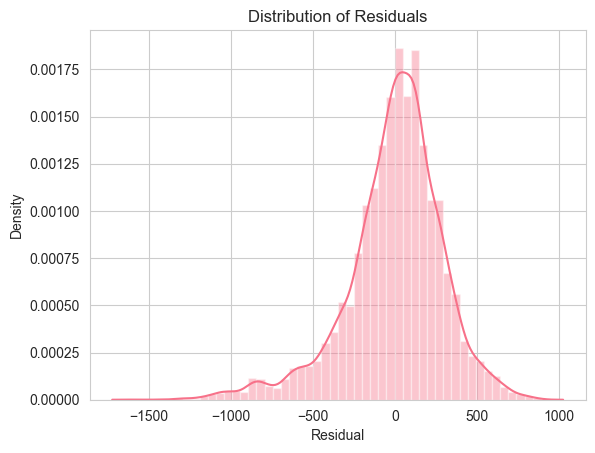

In [19]:
sns.distplot(pred_test- y_test, hist=True, kde=True)
plt.xlabel('Residual')
plt.ylabel('Density')
plt.title('Distribution of Residuals');
plt.show()

# Gaussian Process Regressor

In [20]:
# from sklearn.gaussian_process.kernels import Matern

# kernel_matern = Matern(length_scale=1.0, nu=1.5)
# model = GaussianProcessRegressor(kernel=kernel_matern)

# # Train the model
# for i in tqdm(range(10000)):
#     model.fit(X_train,y_train)
    
# # Make predictions on the test set
# pred_train = model.predict(X_train)
# pred_test = model.predict(X_test)


# # train = plt.scatter(pred_train,y_train-pred_train,c='b',alpha=0.1)
# # test = plt.scatter(pred_test,y_test-pred_test,c='r',alpha=0.1)
# # plt.hlines(y=0, xmin=-1000, xmax=1000, color='green', linestyle='--')

# sns.jointplot(x=y_test, y=pred_test, kind="reg", height=8, joint_kws={'scatter_kws':dict(alpha=0.6)})
# sns.scatterplot(x = pred_test,y=pred_test, color="red", label="test",alpha=0.2)

# mse = mean_squared_error(y_test, pred_test)
# rmse = mse ** 0.5
# gp_model_r2 = r2_score(y_test, pred_test)
# mae = mean_absolute_error(y_test, pred_test)

# print("mse: ", mse)
# print("rmse: ", rmse)
# print("mae: ", mae)
# print("r2_score: ", gp_model_r2)

# Random Forest Regressor


r^2 is  0.793550275616392
MSE Test  64659.43005052802
MSE Train  57294.59991720254


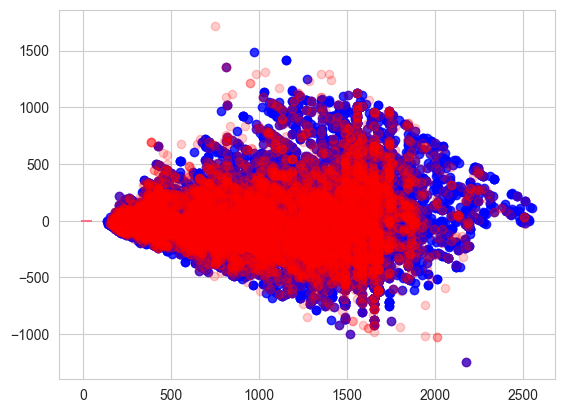

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=6,oob_score=True,max_depth=11)
rf.fit(X_train,y_train)
pred_train = ideal_model.predict(X_train)
pred_test = ideal_model.predict(X_test)
train = plt.scatter(pred_train,y_train-pred_train,c='b',alpha=0.8)
test = plt.scatter(pred_test,y_test-pred_test,c='r',alpha=0.2)
plt.hlines(y=0,xmin=-10,xmax=50)


r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)
print("R2 train:", r2_train)
print("R2 test:", r2_test)

print('MSE Test ',np.mean((pred_test-y_test)**2))
print('MSE Train ',np.mean((pred_train-y_train)**2))

print('MAE Test: ',mean_absolute_error(y_test,pred_test))
print('MAE Train: ',mean_absolute_error(y_train,pred_train))

print('RMSE Test: ',np.sqrt(mean_squared_error(y_test,pred_test)))
print('RMSE Train: ',np.sqrt(mean_squared_error(y_train,pred_train)))

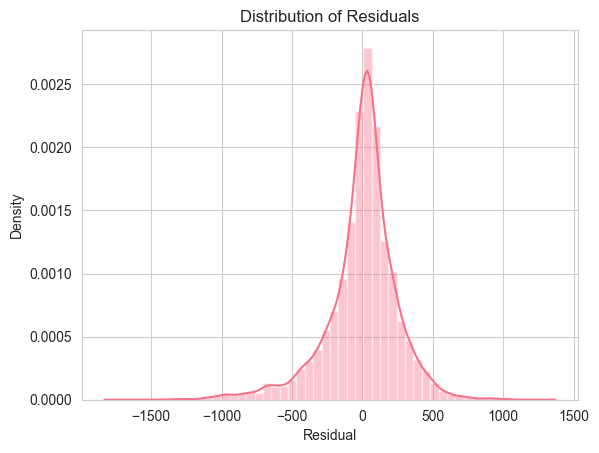

In [22]:
sns.distplot(pred_test- y_test, hist=True, kde=True)
plt.xlabel('Residual')
plt.ylabel('Density')
plt.title('Distribution of Residuals');

# Hyperparmeter tunning

In [23]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=5,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 30.9 s, sys: 205 ms, total: 31.1 s
Wall time: 31 s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [24]:
rs_model.best_params_

{'n_estimators': 30,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [25]:
ideal_model = RandomForestRegressor(n_estimators=20,
                                   min_samples_split=14,
                                   min_samples_leaf=5,
                                   max_samples=10000,
                                   max_features="auto",
                                   max_depth=None)
ideal_model.fit(X_train, y_train)

RandomForestRegressor(max_features='auto', max_samples=10000,
                      min_samples_leaf=5, min_samples_split=14,
                      n_estimators=20)

In [26]:
print("Score:",ideal_model.score(X_test, y_test))

pred_train = ideal_model.predict(X_train)
pred_test = ideal_model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)
print("R2 train:", r2_train)
print("R2 test:", r2_test)

print('MSE Test ',np.mean((pred_test-y_test)**2))
print('MSE Train ',np.mean((pred_train-y_train)**2))

print('MAE Test: ',mean_absolute_error(y_test,pred_test))
print('MAE Train: ',mean_absolute_error(y_train,pred_train))

print('RMSE Test: ',np.sqrt(mean_squared_error(y_test,pred_test)))
print('RMSE Train: ',np.sqrt(mean_squared_error(y_train,pred_train)))

Score: 0.8275703250760837
R2 train: 0.8576908211554377
R2 test: 0.8275703250760837
MSE Test  54004.45332473156
MSE Train  45125.67880311861
MAE Test:  163.8626002254929
MAE Train:  150.2466158089439
RMSE Test:  232.38858260407622
RMSE Train:  212.42805559322574


In [27]:
ideal_model.feature_importances_

array([1.83833001e-01, 1.12324866e-01, 6.11483460e-03, 1.04772899e-01,
       9.31765562e-03, 2.24659880e-02, 7.25040745e-05, 0.00000000e+00,
       8.49384201e-03, 6.14747648e-03, 0.00000000e+00, 3.47151383e-04,
       3.24355135e-03, 5.33567986e-04, 6.80616489e-05, 1.53727596e-04,
       0.00000000e+00, 8.59852328e-03, 1.79233955e-02, 1.68266988e-04,
       5.29993083e-03, 1.08597266e-04, 5.23485174e-05, 6.20881019e-02,
       3.63653043e-02, 7.50820996e-02, 3.47649956e-03, 4.13219840e-02,
       1.80603137e-02, 1.77148565e-02, 1.82032805e-02, 7.62353048e-02,
       2.72648259e-02, 2.31350327e-03, 1.72632270e-02, 7.69947768e-02,
       3.75757336e-02])

In [28]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

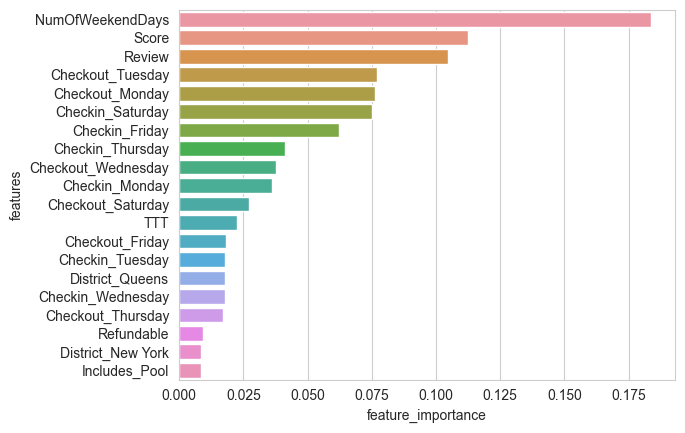

In [29]:
plot_features(X_train.columns, ideal_model.feature_importances_)

# Decision Tree Regressor

r^2 is  0.8645872306348221
MSE Test  42410.870321371076
MSE Train  1783.123498791597


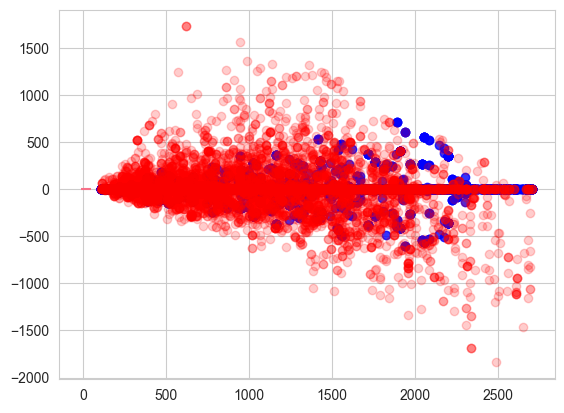

In [30]:

dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)
pred_test = dt.predict(X_test)
pred_train = dt.predict(X_train)
train = plt.scatter(pred_train,y_train-pred_train,c='b',alpha=0.8)
test = plt.scatter(pred_test,y_test-pred_test,c='r',alpha=0.2)
plt.hlines(y=0,xmin=-10,xmax=50)
print("r^2 is ",r2_score(y_test,pred_test))
print('MSE Test ',np.mean((pred_test-y_test)**2))
print('MSE Train ',np.mean((pred_train-y_train)**2))

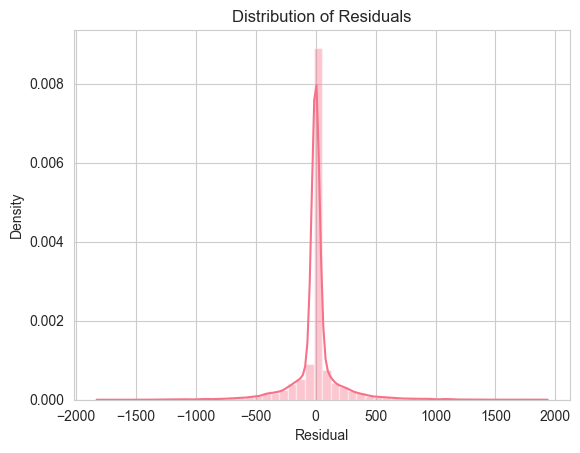

In [31]:
sns.distplot(pred_test- y_test, hist=True, kde=True)
plt.xlabel('Residual')
plt.ylabel('Density')
plt.title('Distribution of Residuals');

# Hyperparameter Tunning 

In [32]:
%%time

# Different Decision Tree hyperparameters
dt_grid = {"criterion":["squared_error", "absolute_error", "poisson"],
           "splitter": ["random", "best"],
           "max_depth": [6,8,10],
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
            }

dt_model = RandomizedSearchCV(DecisionTreeRegressor(),
                              param_distributions=dt_grid,
                              n_iter=20,
                              cv=2,
                              verbose=True)

dt_model.fit(X_train, y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
CPU times: user 37.2 s, sys: 298 ms, total: 37.5 s
Wall time: 37.2 s


RandomizedSearchCV(cv=2, estimator=DecisionTreeRegressor(), n_iter=20,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': [6, 8, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'splitter': ['random', 'best']},
                   verbose=True)

In [33]:
dt_model.best_params_

{'splitter': 'best',
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 10,
 'criterion': 'poisson'}

In [34]:
dt_model = DecisionTreeRegressor(splitter='best',
                                    min_samples_split=19,
                                    max_features='auto',
                                    max_depth=10,
                                    criterion='absolute_error')
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                      max_features='auto', min_samples_split=19)

In [35]:
print("Score:",dt_model.score(X_test, y_test))

pred_train = dt_model.predict(X_train)
pred_test = dt_model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)
print("R2 train:", r2_train)
print("R2 test:", r2_test)

print('MSE Test ',np.mean((pred_test-y_test)**2))
print('MSE Train ',np.mean((pred_train-y_train)**2))

print('MAE Test: ',mean_absolute_error(y_test,pred_test))
print('MAE Train: ',mean_absolute_error(y_train,pred_train))

print('RMSE Test: ',np.sqrt(mean_squared_error(y_test,pred_test)))
print('RMSE Train: ',np.sqrt(mean_squared_error(y_train,pred_train)))

Score: 0.7093897060199403
R2 train: 0.7311382943669845
R2 test: 0.7093897060199403
MSE Test  91018.2662227813
MSE Train  85254.98544339096
MAE Test:  202.86149908909516
MAE Train:  193.7540063208775
RMSE Test:  301.6923370302622
RMSE Train:  291.9845637073833


In [36]:
ideal_model.feature_importances_

array([1.83833001e-01, 1.12324866e-01, 6.11483460e-03, 1.04772899e-01,
       9.31765562e-03, 2.24659880e-02, 7.25040745e-05, 0.00000000e+00,
       8.49384201e-03, 6.14747648e-03, 0.00000000e+00, 3.47151383e-04,
       3.24355135e-03, 5.33567986e-04, 6.80616489e-05, 1.53727596e-04,
       0.00000000e+00, 8.59852328e-03, 1.79233955e-02, 1.68266988e-04,
       5.29993083e-03, 1.08597266e-04, 5.23485174e-05, 6.20881019e-02,
       3.63653043e-02, 7.50820996e-02, 3.47649956e-03, 4.13219840e-02,
       1.80603137e-02, 1.77148565e-02, 1.82032805e-02, 7.62353048e-02,
       2.72648259e-02, 2.31350327e-03, 1.72632270e-02, 7.69947768e-02,
       3.75757336e-02])

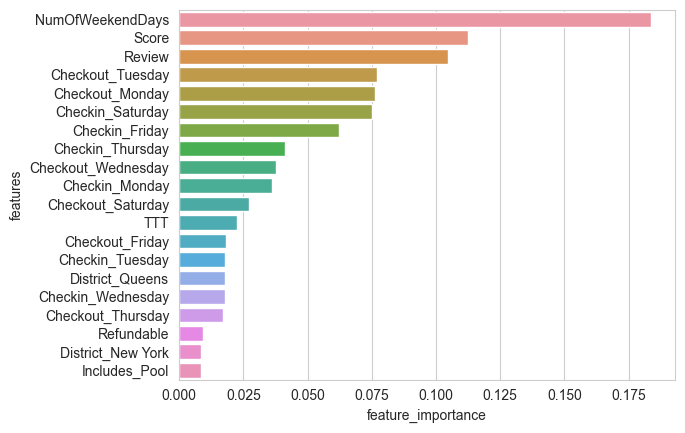

In [37]:
plot_features(X_train.columns, ideal_model.feature_importances_)

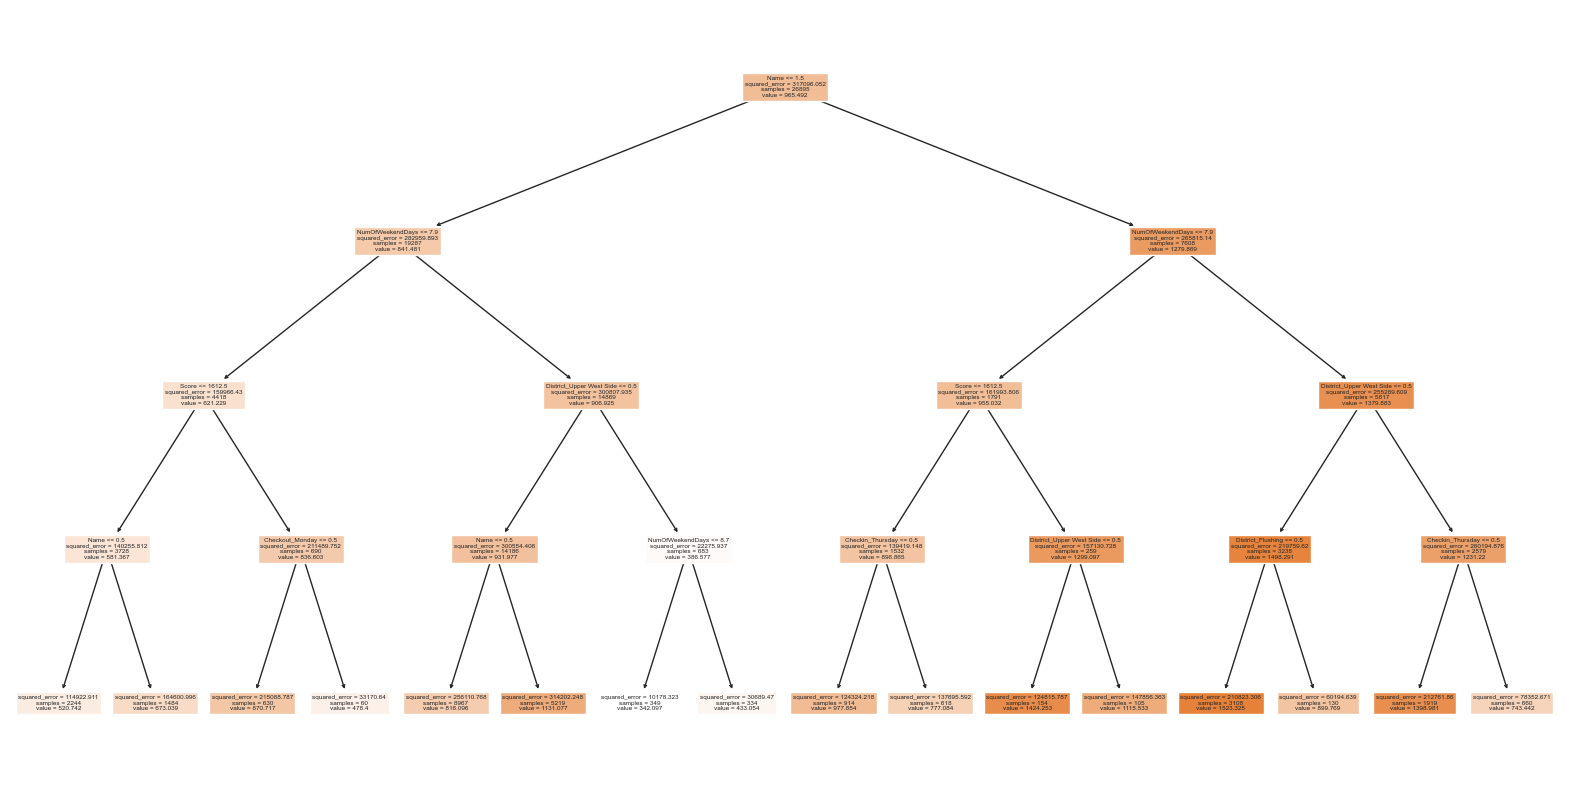

In [38]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
DecisionTree = DecisionTreeRegressor(max_depth=4)
DecisionTree.fit(X_train, y_train)
pred_test = DecisionTree.predict(X_test)
plt.figure(figsize=(20,10))
plot_tree(DecisionTree,feature_names=list(df_cleaned.columns),filled=True);

# Gradient Boost Regressor

r^2 is  0.7703747321950125
MSE Test  71917.94024332073
MSE Train  73118.98251659719


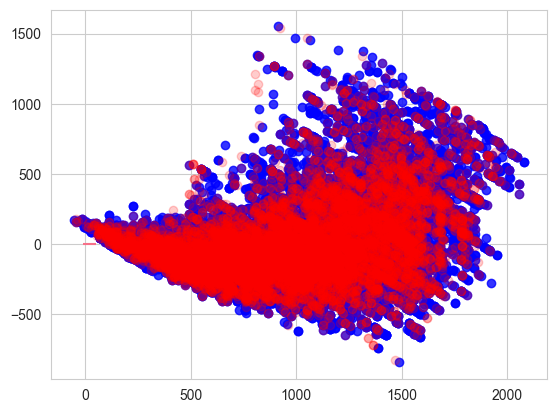

In [39]:
gb = GradientBoostingRegressor()
gb.fit(X_train,y_train)
pred_test = gb.predict(X_test)
pred_train = gb.predict(X_train)
train = plt.scatter(pred_train,y_train-pred_train,c='b',alpha=0.8)
test = plt.scatter(pred_test,y_test-pred_test,c='r',alpha=0.2)
plt.hlines(y=0,xmin=-10,xmax=50)
print("r^2 is ",r2_score(y_test,pred_test))
print('MSE Test ',np.mean((pred_test-y_test)**2))
print('MSE Train ',np.mean((pred_train-y_train)**2))

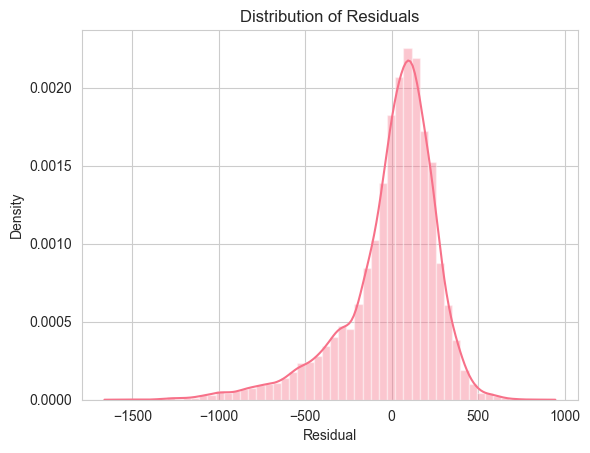

In [40]:
sns.distplot(pred_test- y_test, hist=True, kde=True)
plt.xlabel('Residual')
plt.ylabel('Density')
plt.title('Distribution of Residuals');

# Hyperparameter Tunning 

In [41]:
%%time

# Different Decision Tree hyperparameters
gb_grid = {"n_estimators": np.arange(10,100,20),
            "max_depth": [6,8,12],
            "min_samples_split": [5,8,10],
            "learning_rate": [0.01,0.03,0.01618],
           }

gb_model = RandomizedSearchCV(GradientBoostingRegressor(),
                              param_distributions=gb_grid,
                              n_iter=20,
                              cv=2,
                              verbose=True)

gb_model.fit(X_train, y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
CPU times: user 44.2 s, sys: 200 ms, total: 44.4 s
Wall time: 44.3 s


RandomizedSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_iter=20,
                   param_distributions={'learning_rate': [0.01, 0.03, 0.01618],
                                        'max_depth': [6, 8, 12],
                                        'min_samples_split': [5, 8, 10],
                                        'n_estimators': array([10, 30, 50, 70, 90])},
                   verbose=True)

In [42]:
gb_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 8,
 'max_depth': 12,
 'learning_rate': 0.03}

In [43]:
gb_model = GradientBoostingRegressor(n_estimators=90,
                                    min_samples_leaf=10,
                                    max_depth=8,
                                    learning_rate=0.03)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.03, max_depth=8, min_samples_leaf=10,
                          n_estimators=90)

In [44]:
print("Score:",gb_model.score(X_test, y_test))

pred_train = gb_model.predict(X_train)
pred_test = gb_model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)
print("R2 train:", r2_train)
print("R2 test:", r2_test)

print('MSE Test ',np.mean((pred_test-y_test)**2))
print('MSE Train ',np.mean((pred_train-y_train)**2))

print('MAE Test: ',mean_absolute_error(y_test,pred_test))
print('MAE Train: ',mean_absolute_error(y_train,pred_train))

print('RMSE Test: ',np.sqrt(mean_squared_error(y_test,pred_test)))
print('RMSE Train: ',np.sqrt(mean_squared_error(y_train,pred_train)))

Score: 0.8341097243878232
R2 train: 0.8464508981643437
R2 test: 0.8341097243878232
MSE Test  51956.333213976584
MSE Train  48689.814010601556
MAE Test:  166.1145829970687
MAE Train:  161.39834084192302
RMSE Test:  227.93931914870805
RMSE Train:  220.65768513831907


# XG Boost 

In [45]:

def XGBmodel(X_train,X_test,y_train,y_test,params):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model=xgb.train(params=params,
                    dtrain=matrix_train,num_boost_round=5000, 
                    early_stopping_rounds=10,evals=[(matrix_test,'test')])
    return model

In [46]:
params = {
   
    'max_depth': 7,
    'gamma' :0,
    'eta':.03, 
    'subsample': 1,
    'colsample_bytree': 0.9, 
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 0
}
model = XGBmodel(X_train,X_test,y_train,y_test,params)


[20:35:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:35:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	test-rmse:1078.87922
[1]	test-rmse:1053.39705
[2]	test-rmse:1028.85744
[3]	test-rmse:1001.60164
[4]	test-rmse:975.43904
[5]	test-rmse:950.02436
[6]	test-rmse:925.62542
[7]	test-rmse:904.77151
[8]	test-rmse:881.99421
[9]	test-rmse:859.81280
[10]	test-rmse:838.04695
[11]	test-rmse:817.18740
[12]	test-rmse:797.15037
[13]	test-rmse:777.45677
[14]	test-rmse:758.12876
[15]	test-rmse:739.73317
[16]	test-rmse:721.87500
[17]	test-rmse:705.10800
[18]	test-rmse:688.46612
[19]	test-rmse:672.45785
[20]	test-rmse:657.23674
[21]	test-rmse:642.29016
[22]	test-rmse:627.78693
[23]	test-rmse:614.20951
[24]	test-rms

In [47]:

pred_train = model.predict(xgb.DMatrix(X_train))
pred_test = model.predict(xgb.DMatrix(X_test))
r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)
print("R2 train:", r2_train)
print("R2 test:", r2_test)

print('MSE Test ',np.mean((pred_test-y_test)**2))
print('MSE Train ',np.mean((pred_train-y_train)**2))

print('MAE Test: ',mean_absolute_error(y_test,pred_test))
print('MAE Train: ',mean_absolute_error(y_train,pred_train))

print('RMSE Test: ',np.sqrt(mean_squared_error(y_test,pred_test)))
print('RMSE Train: ',np.sqrt(mean_squared_error(y_train,pred_train)))

R2 train: 0.9784839238853289
R2 test: 0.964167508184473
MSE Test  11222.62819676664
MSE Train  6822.662794749166
MAE Test:  65.67108142268391
MAE Train:  47.862319780074216
RMSE Test:  105.936906679243
RMSE Train:  82.59941158839551


<Axes: xlabel='X'>

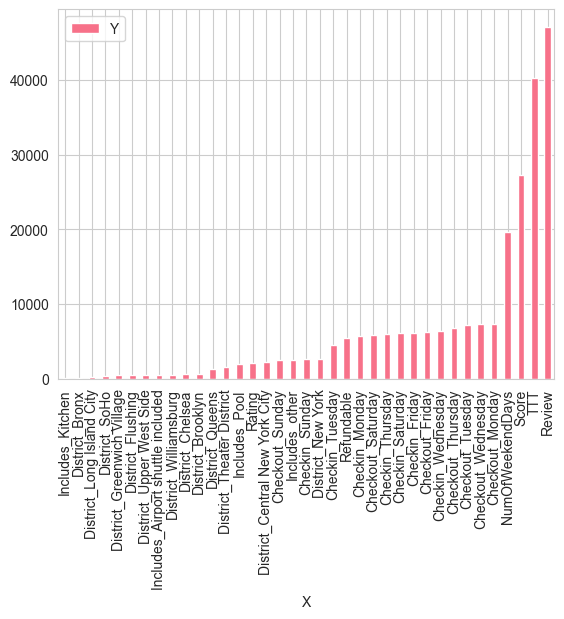

In [48]:
fscores = pd.DataFrame({'X': list(model.get_fscore().keys()), 'Y': list(model.get_fscore().values())})
fscores.sort_values(by='Y').plot.bar(x='X')

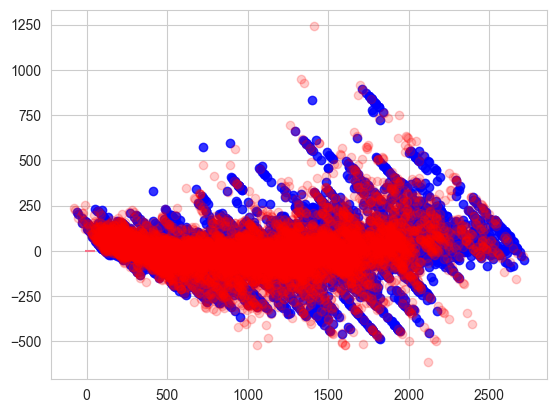

In [49]:
train = plt.scatter(pred_train,y_train-pred_train,c='b',alpha=0.8)
test = plt.scatter(pred_test,y_test-pred_test,c='r',alpha=0.2)
plt.hlines(y=0,xmin=-10,xmax=50);

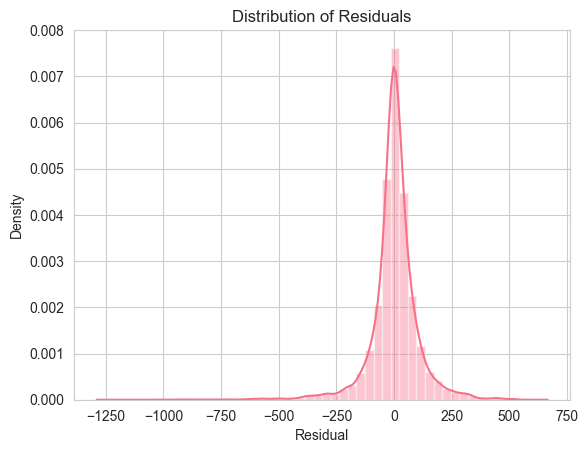

In [50]:
sns.distplot(pred_test- y_test, hist=True, kde=True)
plt.xlabel('Residual')
plt.ylabel('Density')
plt.title('Distribution of Residuals');

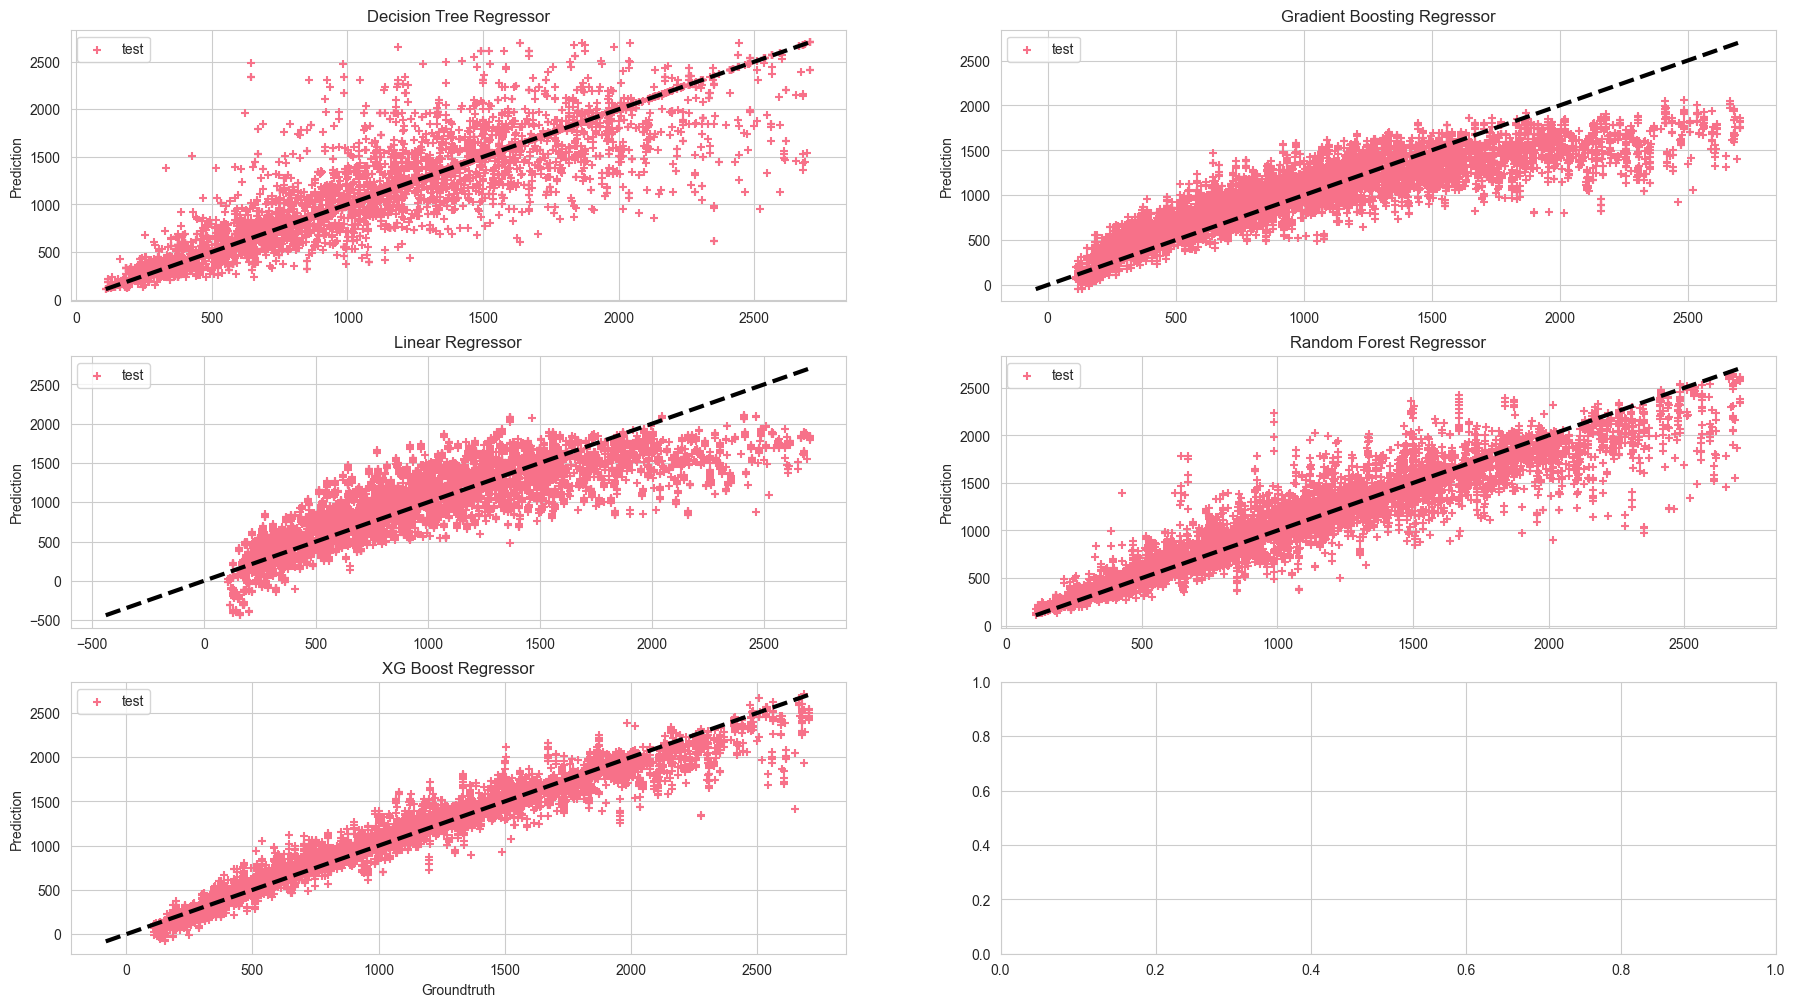

In [51]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(22, 12)) # Create a figure with 2 rows and 2 columns
axs = axs.ravel() # Flatten the array of axes


# First subplot
dt1 = DecisionTreeRegressor()
dt1.fit(X_train, y_train)
pred_test1 = dt1.predict(X_test)
xmin1 = min(y_test.min(), pred_test1.min()) - 1
xmax1 = max(y_test.max(), pred_test1.max()) + 1
axs[0].scatter(y_test, pred_test1, marker='+', label='test')
axs[0].plot([xmin1, xmax1], [xmin1, xmax1], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1
axs[0].set_ylabel('Prediction') 
axs[0].set_title('Decision Tree Regressor')
axs[0].legend()

# Second subplot
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
pred_test2 = gb.predict(X_test)
xmin2 = min(y_test.min(), pred_test2.min()) - 1
xmax2 = max(y_test.max(), pred_test2.max()) + 1
axs[1].scatter(y_test, pred_test2, marker='+', label='test')
axs[1].plot([xmin2, xmax2], [xmin2, xmax2], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1
axs[1].set_ylabel('Prediction') 
axs[1].set_title('Gradient Boosting Regressor')
axs[1].legend()

lr = LinearRegression()
lr.fit(X_train, y_train)
pred_test3 = lr.predict(X_test)
xmin3 = min(y_test.min(), pred_test3.min()) - 1
xmax3 = max(y_test.max(), pred_test3.max()) + 1
axs[2].scatter(y_test, pred_test3, marker='+', label='test')
axs[2].plot([xmin3, xmax3], [xmin3, xmax3], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1
axs[2].set_ylabel('Prediction') 
axs[2].set_title('Linear Regressor')
axs[2].legend()

rf = RandomForestRegressor()
rf.fit(X_train,y_train)
pred_test4 = rf.predict(X_test)
xmin4 = min(y_test.min(), pred_test4.min()) - 1
xmax4 = max(y_test.max(), pred_test4.max()) + 1
axs[3].scatter(y_test, pred_test4, marker='+', label='test')
axs[3].plot([xmin4, xmax4], [xmin4, xmax4], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1
axs[3].set_ylabel('Prediction') 
axs[3].set_title('Random Forest Regressor')
axs[3].legend()




xmin5 = min(y_test.min(), pred_test.min()) - 1
xmax5 = max(y_test.max(), pred_test.max()) + 1
axs[4].scatter(y_test, pred_test, marker='+', label='test')
axs[4].plot([xmin5, xmax5], [xmin5, xmax5], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1
axs[4].set_xlabel('Groundtruth')
axs[4].set_ylabel('Prediction') 
axs[4].set_title('XG Boost Regressor')
axs[4].legend()
plt.show()


# So far it seems that XG Boost is the best model 

In [52]:
df_cleaned

,Name,NumOfWeekendDays,Nights,Score,Rating,Review,Refundable,Price,TTT,Includes_Airport shuttle included,...,Checkin_Thursday,Checkin_Tuesday,Checkin_Wednesday,Checkout_Friday,Checkout_Monday,Checkout_Saturday,Checkout_Sunday,Checkout_Thursday,Checkout_Tuesday,Checkout_Wednesday
0,The Hoxton Williamsburg,0.0,1.0,9.0,3.0,1000.000000,1,347,1,0,...,1,0,0,1,0,0,0,0,0,0
1,Hampton Inn Manhattan/Times Square Central,0.0,1.0,8.6,2.0,1338.000000,1,381,1,0,...,1,0,0,1,0,0,0,0,0,0
2,Cachet Boutique New York,0.0,1.0,7.6,0.0,1002.000000,0,287,1,0,...,1,0,0,1,0,0,0,0,0,0
3,"PUBLIC, an Ian Schrager hotel",0.0,1.0,8.0,1.0,1447.000000,0,446,1,0,...,1,0,0,1,0,0,0,0,0,0
4,Hampton Inn NY-JFK,0.0,1.0,7.6,0.0,1216.000000,0,181,1,0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40491,Fitzpatrick Grand Central,2.0,5.0,9.0,3.0,1000.000000,1,1840,3,0,...,0,0,0,0,0,0,0,1,0,0
40492,Fitzpatrick Manhattan Hotel,2.0,5.0,8.8,2.0,1001.000000,1,1900,3,0,...,0,0,0,0,0,0,0,1,0,0
40493,Hilton Club West 57th Street New York,2.0,5.0,9.2,3.0,223.000000,0,1975,3,0,...,0,0,0,0,0,0,0,1,0,0
40494,Roxy Hotel New York,2.0,5.0,9.0,3.0,1000.000000,1,2560,3,0,...,0,0,0,0,0,0,0,1,0,0


# Now lets try to predict the price using TTT:

In [53]:
train = df_cleaned[df_cleaned['TTT'] <= 20]
valid = df_cleaned[(df_cleaned['TTT'] > 20) & (df_cleaned['TTT'] <= 25)]
test = df_cleaned[df_cleaned['TTT'] > 25]

# For train set
X_train = train.drop(['Price','Name'], axis=1)
y_train = train['Price']

# For validation set
X_valid = valid.drop(['Price','Name'], axis=1)
y_valid = valid['Price']

# For test set
X_test = test.drop(['Price','Name'], axis=1)
y_test = test['Price']


In [54]:
def XGBmodel_val(X_train,X_val,X_test,y_train,y_val,y_test,params):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_val = xgb.DMatrix(X_val,label=y_val)
    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model=xgb.train(params=params,
                    dtrain=matrix_train,
                    num_boost_round=5000,
                    early_stopping_rounds=10,
                    evals=[(matrix_train, 'train'), (matrix_val, 'val')])

    return model

params = {   
    'max_depth': 7,
    'gamma' :0,
    'eta':.03, 
    'subsample': 1,
    'colsample_bytree': 0.9, 
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 0
}

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = XGBmodel_val(X_train, X_val, X_test, y_train, y_val, y_test, params)


[20:36:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:36:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:1076.29708	val-rmse:1088.38451
[1]	train-rmse:1046.06626	val-rmse:1058.27484
[2]	train-rmse:1016.77636	val-rmse:1029.12343
[3]	train-rmse:989.65056	val-rmse:1002.18609
[4]	train-rmse:962.15666	val-rmse:974.78596
[5]	train-rmse:935.51414	val-rmse:948.21344
[6]	train-rmse:909.84942	val-rmse:922.62062
[7]	train-rmse:884.87445	val-rmse:897.78502
[8]	train-rmse:860.69697	val-rmse:873.68334
[9]	train-rmse:837.29357	val-rmse:850.35330
[10]	train-rmse:818.44943	val-rmse:831.63433
[11]	train-rmse:796.61856	val-rmse:809.90564
[12]	train-rmse:775.23437	val-rmse:788.60988
[13]	train-rmse:755.66462

In [55]:

pred_train = model.predict(xgb.DMatrix(X_train))
pred_test = model.predict(xgb.DMatrix(X_test))
r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)
print("R2 train:", r2_train)
print("R2 test:", r2_test)

print('MSE Test ',np.mean((pred_test-y_test)**2))
print('MSE Train ',np.mean((pred_train-y_train)**2))

print('MAE Test: ',mean_absolute_error(y_test,pred_test))
print('MAE Train: ',mean_absolute_error(y_train,pred_train))

print('RMSE Test: ',np.sqrt(mean_squared_error(y_test,pred_test)))
print('RMSE Train: ',np.sqrt(mean_squared_error(y_train,pred_train)))

R2 train: 0.9852337633611112
R2 test: 0.9750833924838499
MSE Test  7846.750722016445
MSE Train  4638.111552730486
MAE Test:  45.831651759920945
MAE Train:  30.304402036088778
RMSE Test:  88.58188709898003
RMSE Train:  68.10368237276518


# Phase 4 - Booking vs Expedia Price Comperation 

#### Pre Processing

In [56]:
df_booking  = pd.read_csv("newYorkBookingPartB.csv", index_col=0)

In [57]:
df_booking.Price = round(df_booking.Price / 3.56)

In [58]:
df_cleaned = df_cleaned.drop_duplicates()
df_cleaned

,Name,NumOfWeekendDays,Nights,Score,Rating,Review,Refundable,Price,TTT,Includes_Airport shuttle included,...,Checkin_Thursday,Checkin_Tuesday,Checkin_Wednesday,Checkout_Friday,Checkout_Monday,Checkout_Saturday,Checkout_Sunday,Checkout_Thursday,Checkout_Tuesday,Checkout_Wednesday
0,The Hoxton Williamsburg,0.0,1.0,9.0,3.0,1000.000000,1,347,1,0,...,1,0,0,1,0,0,0,0,0,0
1,Hampton Inn Manhattan/Times Square Central,0.0,1.0,8.6,2.0,1338.000000,1,381,1,0,...,1,0,0,1,0,0,0,0,0,0
2,Cachet Boutique New York,0.0,1.0,7.6,0.0,1002.000000,0,287,1,0,...,1,0,0,1,0,0,0,0,0,0
3,"PUBLIC, an Ian Schrager hotel",0.0,1.0,8.0,1.0,1447.000000,0,446,1,0,...,1,0,0,1,0,0,0,0,0,0
4,Hampton Inn NY-JFK,0.0,1.0,7.6,0.0,1216.000000,0,181,1,0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40491,Fitzpatrick Grand Central,2.0,5.0,9.0,3.0,1000.000000,1,1840,3,0,...,0,0,0,0,0,0,0,1,0,0
40492,Fitzpatrick Manhattan Hotel,2.0,5.0,8.8,2.0,1001.000000,1,1900,3,0,...,0,0,0,0,0,0,0,1,0,0
40493,Hilton Club West 57th Street New York,2.0,5.0,9.2,3.0,223.000000,0,1975,3,0,...,0,0,0,0,0,0,0,1,0,0
40494,Roxy Hotel New York,2.0,5.0,9.0,3.0,1000.000000,1,2560,3,0,...,0,0,0,0,0,0,0,1,0,0


In [59]:
df_booking = df_booking.drop_duplicates()

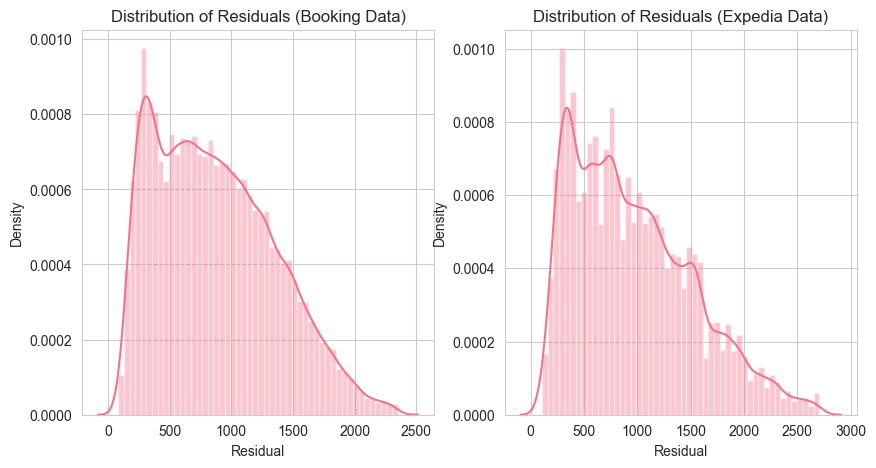

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

sns.distplot(df_booking.Price, hist=True, kde=True, ax=axs[0])
axs[0].set_xlabel('Residual')
axs[0].set_ylabel('Density')
axs[0].set_title('Distribution of Residuals (Booking Data)')

sns.distplot(df_cleaned.Price, hist=True, kde=True, ax=axs[1])
axs[1].set_xlabel('Residual')
axs[1].set_ylabel('Density')
axs[1].set_title('Distribution of Residuals (Expedia Data)')

plt.show()

In [61]:
df_cleaned.rename(columns={"Name":"Hotel Name", "Nights":"LOS", "Review":"Reviews", "Refundable":"Cancellation", "Rating":"Score_in_the_description"}, inplace=True)

In [62]:
df_cleaned.columns

Index(['Hotel Name', 'NumOfWeekendDays', 'LOS', 'Score',
       'Score_in_the_description', 'Reviews', 'Cancellation', 'Price', 'TTT',
       'Includes_Airport shuttle included', 'Includes_Breakfast included',
       'Includes_Kitchen', 'Includes_Pool', 'Includes_other', 'District_Bronx',
       'District_Brooklyn', 'District_Central New York City',
       'District_Chelsea', 'District_Flushing', 'District_Greenwich Village',
       'District_Long Island City', 'District_New York', 'District_Queens',
       'District_SoHo', 'District_Theater District',
       'District_Upper West Side', 'District_Williamsburg', 'Checkin_Friday',
       'Checkin_Monday', 'Checkin_Saturday', 'Checkin_Sunday',
       'Checkin_Thursday', 'Checkin_Tuesday', 'Checkin_Wednesday',
       'Checkout_Friday', 'Checkout_Monday', 'Checkout_Saturday',
       'Checkout_Sunday', 'Checkout_Thursday', 'Checkout_Tuesday',
       'Checkout_Wednesday'],
      dtype='object')

In [63]:
df_booking.columns

Index(['LOS', 'Hotel Name', 'Price', 'Reviews', 'Score',
       'Score_in_the_description', 'Cancellation', 'prepayment', 'typeBed',
       'DistanceFromCenter', 'Stars', 'Index', 'day_of_week_chek_in',
       'day_of_week_chek_out', 'Locatins_Battery Park', 'Locatins_Boerum Hill',
       'Locatins_Chelsea', 'Locatins_Chinatown', 'Locatins_Downtown Brooklyn',
       'Locatins_Downtown Jersey City', 'Locatins_East Harlem',
       'Locatins_East Village', 'Locatins_Flatiron District',
       'Locatins_Gramercy', 'Locatins_Greenwich Village', 'Locatins_Harlem',
       'Locatins_Hell's Kitchen', 'Locatins_Hoboken', 'Locatins_Hudson Yards',
       'Locatins_Jersey City', 'Locatins_Kips Bay',
       'Locatins_Long Island City', 'Locatins_Lower East Side',
       'Locatins_Manhattan', 'Locatins_Midtown East', 'Locatins_Murray Hill',
       'Locatins_New York', 'Locatins_Newport', 'Locatins_NoMad',
       'Locatins_SoHo', 'Locatins_Tribeca', 'Locatins_Union Square',
       'Locatins_Upper East

In [64]:
 booking = df_booking.drop(set(df_booking.columns)-set(df_cleaned.columns), axis=1) 
    

In [65]:
 expedia = df_cleaned.drop(set(df_cleaned.columns)-set(df_booking.columns), axis=1) 

# Outliers Removal

In [66]:
Q1 = booking['Price'].quantile(0.25)
Q3 = booking['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

booking = booking[(booking['Price'] >= lower_bound) & (booking['Price'] <= upper_bound)]

In [67]:
Q1 = expedia['Price'].quantile(0.25)
Q3 = expedia['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

expedia = expedia[(expedia['Price'] >= lower_bound) & (expedia['Price'] <= upper_bound)]

# Merge

In [68]:
merged_df = booking.merge(expedia, on=["Hotel Name", "LOS"], how ='inner')
merged_df.drop_duplicates(inplace=True)

In [69]:
merged_df["target"] = merged_df["Price_y"] - merged_df["Price_x"] 

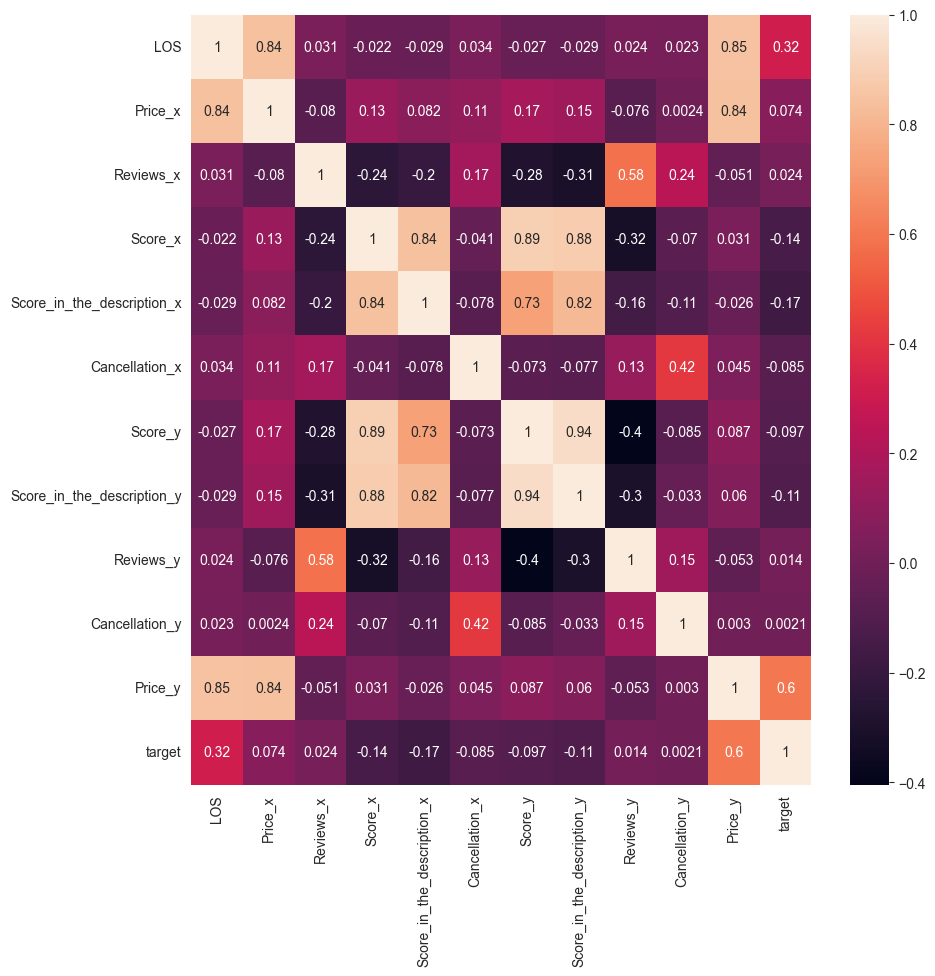

In [70]:
plt.figure(figsize=(10,10))
sns.heatmap(data=merged_df.corr(), annot=True);

In [71]:
X = merged_df.drop(['target', 'Price_x', 'Price_y','Hotel Name', 'Score_x', 'Score_y'], axis=1)
y = merged_df['target']

# Split the data into train, validation & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [72]:
params = {
   
    'max_depth': 7,
    'gamma' :0,
    'eta':.03, 
    'subsample': 1,
    'colsample_bytree': 0.9, 
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 0
}

model = XGBmodel(X_train,X_test,y_train,y_test,params)

[20:37:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	test-rmse:381.88172
[1]	test-rmse:375.02312
[2]	test-rmse:368.31380
[3]	test-rmse:361.98178
[4]	test-rmse:355.86913
[5]	test-rmse:350.13634
[6]	test-rmse:343.95351
[7]	test-rmse:338.57227
[8]	test-rmse:333.63978
[9]	test-rmse:328.85713
[10]	test-rmse:323.72271
[11]	test-rmse:319.13570
[12]	test-rmse:314.60602
[13]	test-rmse:310.45601
[14]	test-rmse:305.96845
[15]	test-rmse:302.13727
[16]	test-rmse:297.72563
[17]	test-rmse:293.48776
[18]	test-rmse:290.04664
[19]	test-rmse:286.60632
[20]	test-rmse:283.31160
[21]	test-rmse:280.24710
[22]	test-rmse:276.66912
[23]	test-rmse:273.55373
[24]	test-rmse:27

In [73]:

pred_train = model.predict(xgb.DMatrix(X_train))
pred_test = model.predict(xgb.DMatrix(X_test))
r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)
print("R2 train:", r2_train)
print("R2 test:", r2_test)

print('MSE Test ',np.mean((pred_test-y_test)**2))
print('MSE Train ',np.mean((pred_train-y_train)**2))

print('MAE Test: ',mean_absolute_error(y_test,pred_test))
print('MAE Train: ',mean_absolute_error(y_train,pred_train))

print('RMSE Test: ',np.sqrt(mean_squared_error(y_test,pred_test)))
print('RMSE Train: ',np.sqrt(mean_squared_error(y_train,pred_train)))

R2 train: 0.811986751866932
R2 test: 0.7857814917239037
MSE Test  21973.06892717733
MSE Train  19576.67878900888
MAE Test:  111.03116038833546
MAE Train:  104.36963090084163
RMSE Test:  148.23315731366355
RMSE Train:  139.91668517017146


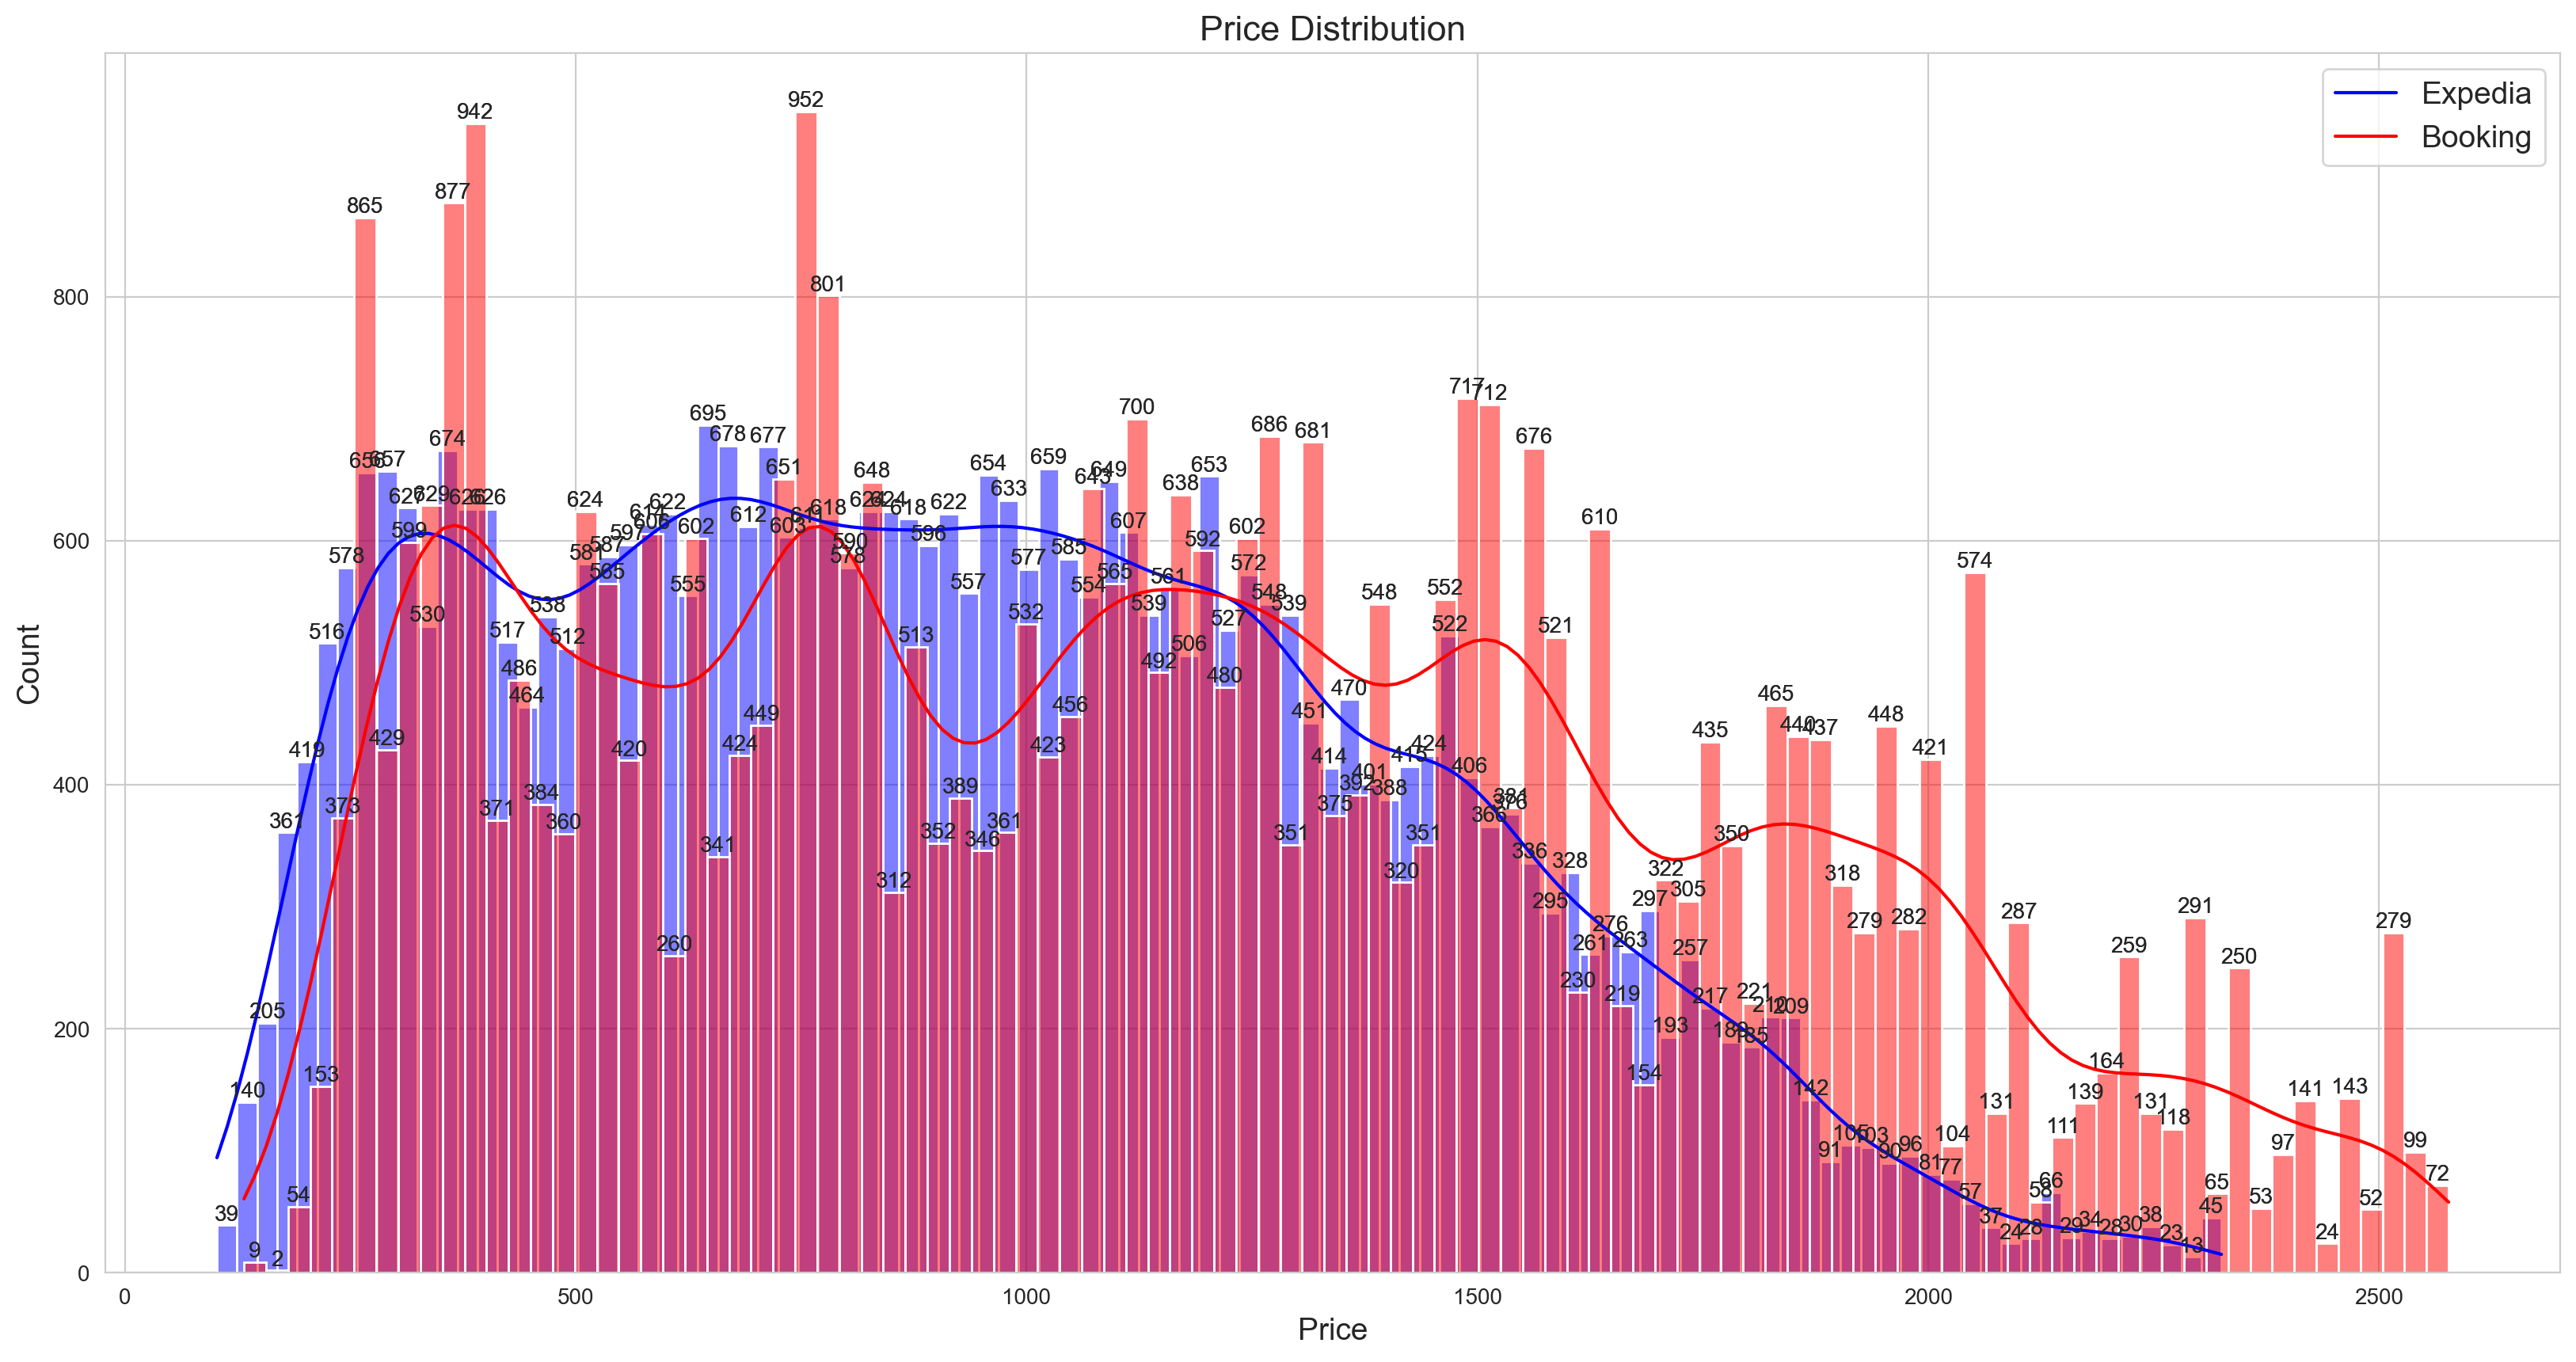

In [74]:
%config InlineBackend.figure_format ='retina'
plt.figure(figsize=(20, 10))

ax = sns.histplot(merged_df['Price_x'], bins=100, kde=True, alpha=0.5, color='blue')
bx = sns.histplot(merged_df['Price_y'], bins=100, kde=True, alpha=0.5, color='red')

plt.legend(['Expedia', 'Booking'], fontsize=14)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Price Distribution', fontsize=16)

for rect in ax.patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height, int(height), ha='center', va='bottom', fontsize=10)

for rect in bx.patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height, int(height), ha='center', va='bottom', fontsize=10)

plt.show()

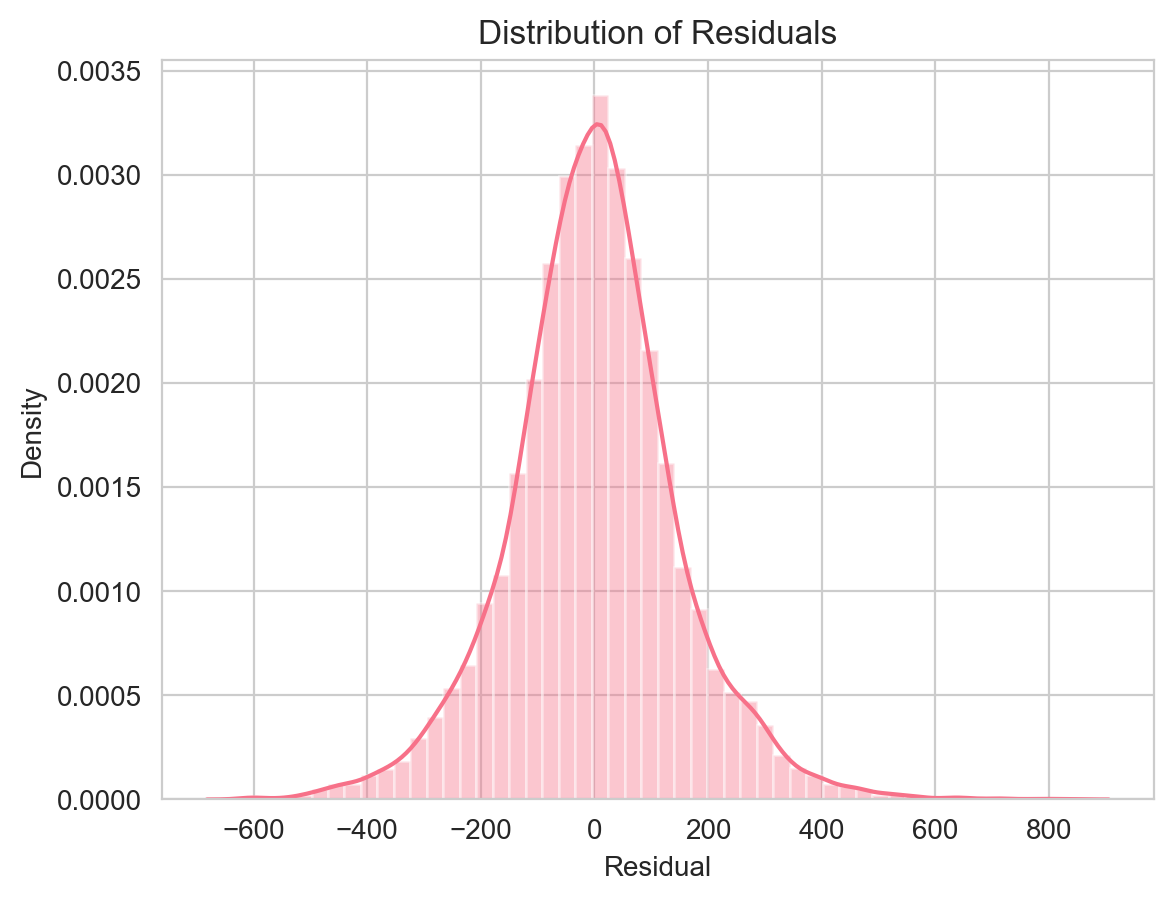

In [75]:
sns.distplot(pred_test- y_test, hist=True, kde=True)
plt.xlabel('Residual')
plt.ylabel('Density')
plt.title('Distribution of Residuals');

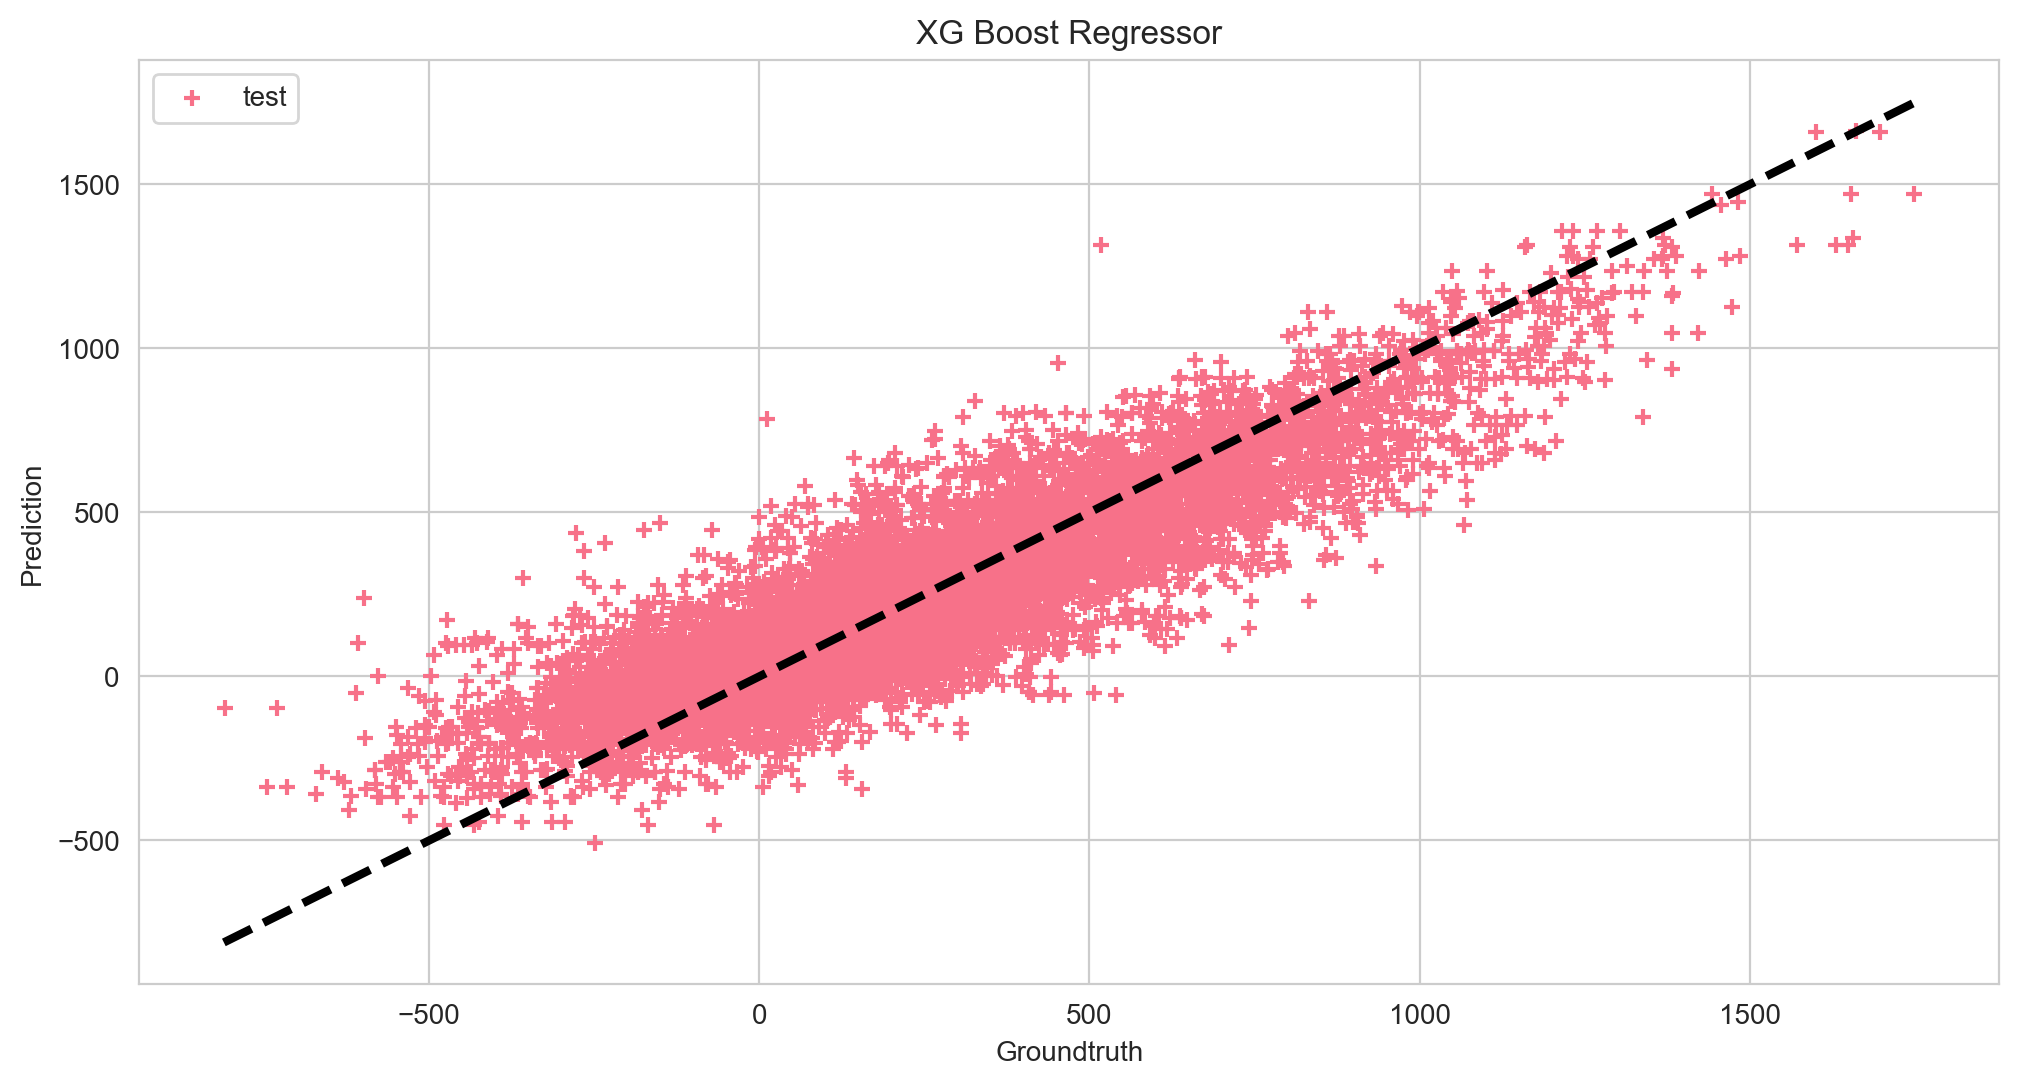

In [76]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6)) # Create a figure with 2 rows and 2 columns

# First subplot
xmin1 = min(y_test.min(), pred_test.min()) - 1
xmax1 = max(y_test.max(), pred_test.max()) + 1
axs.scatter(y_test, pred_test, marker='+', label='test')
axs.plot([xmin1, xmax1], [xmin1, xmax1], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1
axs.set_xlabel('Groundtruth')
axs.set_ylabel('Prediction') 
axs.set_title('XG Boost Regressor')
axs.legend()

# Now lets try with the Random Forest Regressor

r^2 is  0.7194094134663247
MSE Test  28781.062606762338
MSE Train  26526.12733156943


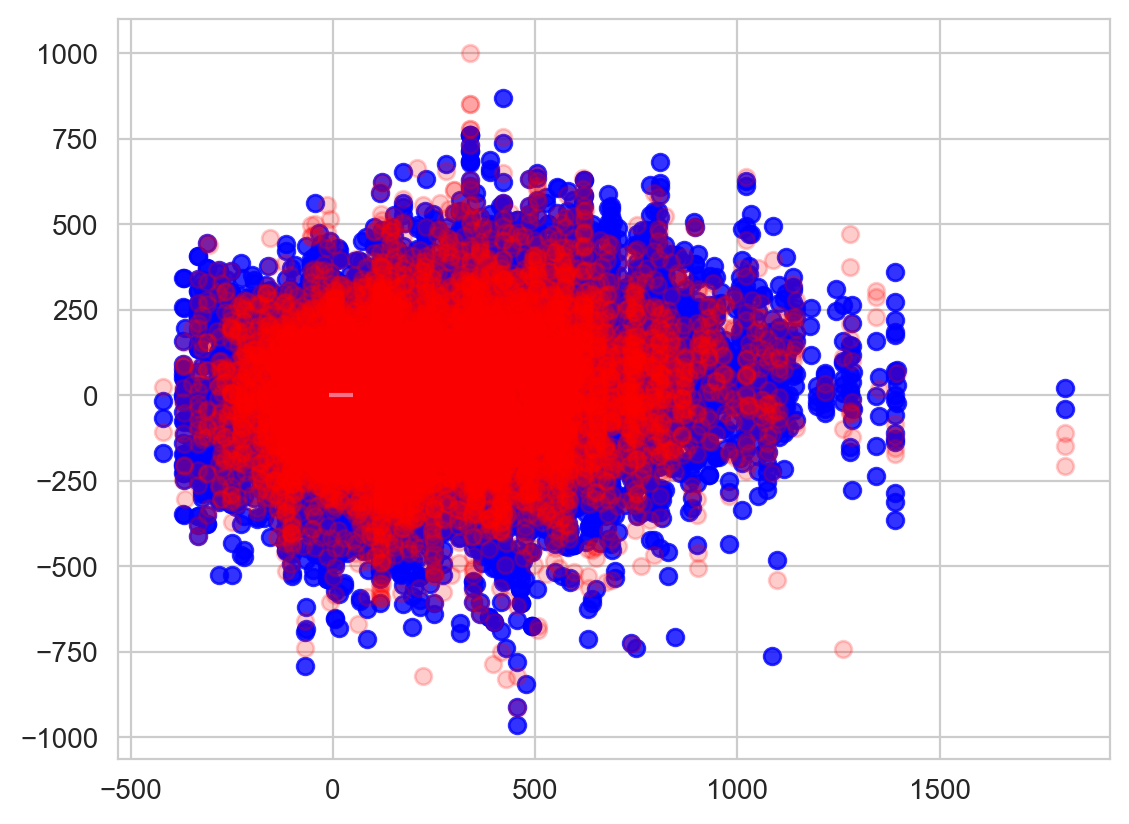

In [77]:
rf = RandomForestRegressor(n_estimators=6,oob_score=True,max_depth=11)
rf.fit(X_train,y_train)
pred_test = rf.predict(X_test)
pred_train = rf.predict(X_train)
train = plt.scatter(pred_train,y_train-pred_train,c='b',alpha=0.8)
test = plt.scatter(pred_test,y_test-pred_test,c='r',alpha=0.2)
plt.hlines(y=0,xmin=-10,xmax=50)
print("r^2 is ",r2_score(y_test,pred_test))
print('MSE Test ',np.mean((pred_test-y_test)**2))
print('MSE Train ',np.mean((pred_train-y_train)**2))


# Hyperparameter Tunnig 

In [78]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=5,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 21.5 s, sys: 202 ms, total: 21.7 s
Wall time: 21.7 s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [79]:
rs_model.best_params_

{'n_estimators': 70,
 'min_samples_split': 10,
 'min_samples_leaf': 9,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [81]:
rs_model = RandomForestRegressor(n_estimators=30,
                                   min_samples_split=14,
                                   min_samples_leaf=5,
                                   max_samples=10000,
                                   max_features="auto",
                                   max_depth=None)
rs_model.fit(X_train, y_train)

RandomForestRegressor(max_features='auto', max_samples=10000,
                      min_samples_leaf=5, min_samples_split=14,
                      n_estimators=30)

In [83]:
print("Score:",rs_model.score(X_test, y_test))

pred_train = rs_model.predict(X_train)
pred_test = rs_model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)
print("R2 train:", r2_train)
print("R2 test:", r2_test)

print('MSE Test ',np.mean((pred_test-y_test)**2))
print('MSE Train ',np.mean((pred_train-y_train)**2))

print('MAE Test: ',mean_absolute_error(y_test,pred_test))
print('MAE Train: ',mean_absolute_error(y_train,pred_train))

print('RMSE Test: ',np.sqrt(mean_squared_error(y_test,pred_test)))
print('RMSE Train: ',np.sqrt(mean_squared_error(y_train,pred_train)))

Score: 0.7561995951893427
R2 train: 0.779805260544593
R2 test: 0.7561995951893427
MSE Test  25007.377478671748
MSE Train  22927.542224562196
MAE Test:  119.84074932237196
MAE Train:  114.61012220753777
RMSE Test:  158.137210923526
RMSE Train:  151.41843422966107
